In [1]:
import numpy as np
import serpentine as sp
import cooler
import hicstuff.view as hcv
import hicstuff.hicstuff as hcs
import hicstuff.io as hio
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from cooltools.lib.numutils import coarsen
print(cooler.__version__)
print(sp.__version__)

0.9.3
0.1.3


In [2]:
cooldir="/mnt/e/Science/HiC/Contact_files/Cool/S288c/"
out_dir="/mnt/f/Nextcloud/DR07_UMR5239_Experiments/HiC/Serpentine/DSB/"


Load data and perform a subsampling on the whole matrix

In [3]:
# 1) Load cooler matrices binned at 1kb in COO sparse + fragments + chroms

inputA = "AD280_AD284_AD336_AD362_S288c_DSB_chr3_rDNA_cutsite_q20_v312" #write sample name A here e.g. AP47
inputB = "CD1_S288c_DSB_chr3_rDNA_RE_N_cutsite_q20_v312"

cool1 = str(cooldir + inputA + "_1kb.cool")   # or "file1.cool"
cool2 = str(cooldir + inputB + "_1kb.cool") 

mat1, frags1, chroms1 = hio.flexible_hic_loader(cool1)
mat2, frags2, chroms2 = hio.flexible_hic_loader(cool2)

# 2) Compute total contacts (sum of matrix entries)
total1 = mat1.data.sum()
total2 = mat2.data.sum()
print("Total contacts:", total1, total2)

# 3) Subsample the larger to match the smaller
if total1 > total2:
    target = total2
    mat1_sub = hcs.subsample_contacts(mat1, target)
    mat2_sub = mat2
    frags_sub = frags1   # keep frags from mat1
    out_prefix = "file1_subsampled"
else:
    target = total1
    mat2_sub = hcs.subsample_contacts(mat2, target)
    mat1_sub = mat1
    frags_sub = frags2
    out_prefix = "file2_subsampled"

print("Subsampled to", target, "contacts")

#convert matrices from COO to dense format
dense1=hcv.sparse_to_dense(mat1_sub, remove_diag=False)
dense2=hcv.sparse_to_dense(mat2_sub, remove_diag=False)


Total contacts: 130119124 32131126
Subsampled to 32131126 contacts


Isolate a single chromosome

6150372.0
6117090


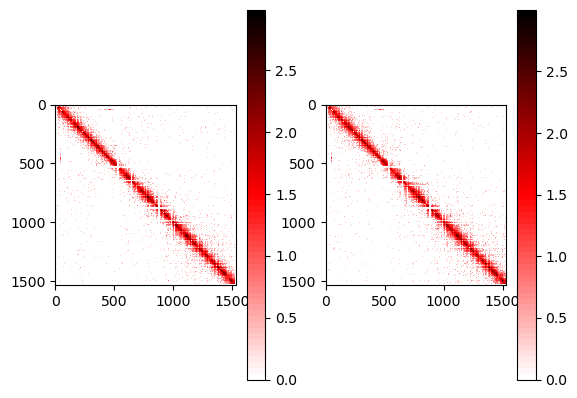

In [26]:

#chrom="chr4"
chrom="chr3"
start = min(frags1[(frags1["chrom"]== chrom)].index.values)
stop = max(frags1[(frags1["chrom"]== chrom)].index.values)

cA=dense1[start:stop,start:stop]
cB=dense2[start:stop,start:stop]

print(cA.sum())
print(cB.sum())

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1); sp.mshow(cA, subplot=ax1)
ax2 = fig.add_subplot(1, 2, 2); sp.mshow(cB, subplot=ax2)

1556387.0
1552697


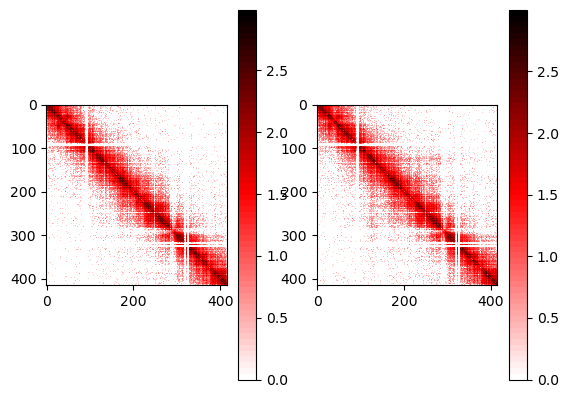

In [27]:
#reduce the window size in case of RE-DSB on chr4
start = 555
stop = 970
cA=cA[start:stop,start:stop]
cB=cB[start:stop,start:stop]
print(cA.sum())
print(cB.sum())

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1); sp.mshow(cA, subplot=ax1)
ax2 = fig.add_subplot(1, 2, 2); sp.mshow(cB, subplot=ax2)

Isolate an intersection (eg between v1 and v2)

In [37]:
#remove the DSB bin on chr3 if one is broken and not the other one (eg. DSB on chr5) 
cA[:,194:208]=0    
cB[:,194:208]=0    

cA[194:208,:]=0    
cB[194:208,:]=0  

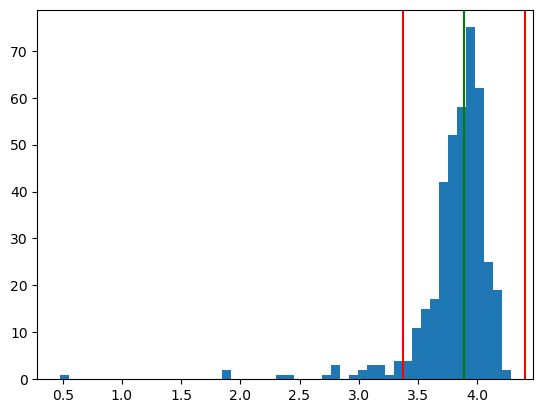

In [28]:
#The raw data needs to be filtered in order to clean the unmappable rows and columns, this kind of artifacts shows up in the distribution of reads per bin as outliers:

plt.figure()
norm = np.log10(np.sum(cA + cB, axis=0)[np.sum(cA + cB, axis=0) > 0])
norm = norm[np.isnan(norm) == False]
norm = norm[np.isinf(np.abs(norm)) == False]
plt.hist(norm, bins=50)
plt.axvline(x=np.median(norm), color='g')
plt.axvline(x=np.median(norm) - 3 * 1.4826 * sp.mad(norm), color='r')
plt.axvline(x=np.median(norm) + 3 * 1.4826 * sp.mad(norm), color='r')

Serpenting binning the data

Finally you can use the function to bin the data. The function takes two parameters: a threshold that constrains the coverage of the bin in at least one matrix, and the minthreshold that constrain it in both. The function uses multiple processors and can be configured by the optional parameters:

-0.009108064813516835 49.999999999999986
Starting 30 binning processes in batches of 4...
0	 Total serpentines: 172225 (100.0 %)
0	 Total serpentines: 172225 (100.0 %)
0	 Total serpentines: 172225 (100.0 %)
0	 Total serpentines: 172225 (100.0 %)
1	 Total serpentines: 116835 (67.83858324865729 %)
1	 Total serpentines: 116941 (67.90013064305414 %)
1	 Total serpentines: 116978 (67.92161416751343 %)
1	 Total serpentines: 116914 (67.88445347655683 %)
2	 Total serpentines: 45821 (26.6053128175352 %)
2	 Total serpentines: 46010 (26.715052983016403 %)
2	 Total serpentines: 45931 (26.669182755116854 %)
2	 Total serpentines: 45882 (26.64073160110321 %)
3	 Total serpentines: 23764 (13.7982290608216 %)
3	 Total serpentines: 23654 (13.734359123239948 %)
3	 Total serpentines: 23675 (13.746552474960081 %)
3	 Total serpentines: 23684 (13.751778197125853 %)
4	 Total serpentines: 17002 (9.871969806938598 %)
4	 Total serpentines: 17000 (9.870808535346205 %)
4	 Total serpentines: 17005 (9.873711714327188 

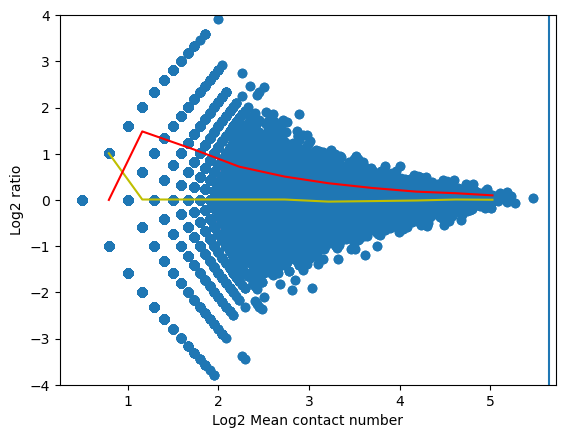

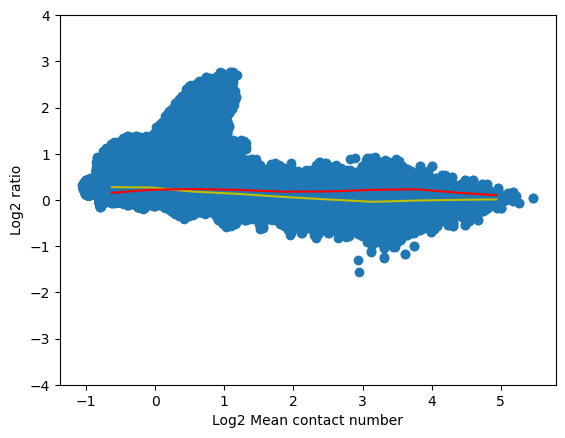

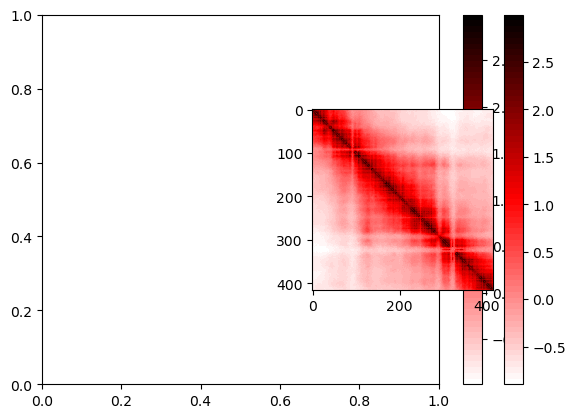

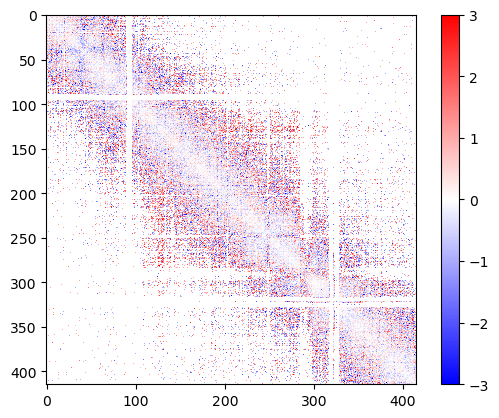

In [29]:
high = 50 #default 50 or threshold
low = 5 #default 5 or threshold/5
cycles = 30

plt.figure()
trend, threshold = sp.MDbefore(cA, cB, ylim=[-4, 4])
print(trend, threshold)

from scipy.ndimage import gaussian_filter
sA, sB, sK = sp.serpentin_binning(cA, cB, high, low, cycles)

#check binning quality
plt.figure()
sp.MDafter(sA, sB, sK, ylim=[-4, 4])

fig = plt.figure();
sp.mshow(sA, subplot=ax1)
ax2 = fig.add_subplot(1, 2, 2)
sp.mshow(sB, subplot=ax2)

plt.figure()
np.warnings.filterwarnings('ignore')
D = np.log2(cB/cA)
sp.dshow(D, trend, cmap= "bwr")


Compute ratio of both maps. Set limits to colorscale (log2). By default set the trend constat to 0.

CD1_S288c_DSB_chr3_rDNA_RE_N_cutsite_q20_v312 over CD2_S288c_DSB_chr3_rDNA_RE_N_cutsite_q20_v312
mean= 0.21636076993488781  trend= -0.009108064813516835


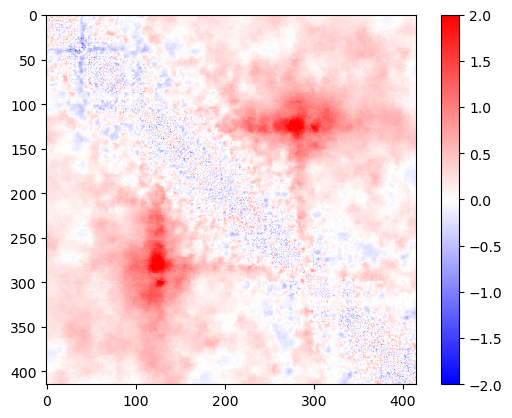

In [33]:
lim = 2
tr = 0
#tr = np.mean(sK)
print(str(inputB), "over", str(inputA))
print("mean=", np.mean(sK), " trend=", trend)
sp.dshow(sK, tr, cmap="bwr", limit = lim)
plt.savefig(str(out_dir + inputB + "over" + inputA + "_" + chrom + "_1kb_tr_mean_" + str(tr) + "_lim_" 
                + str(lim) + "_high-low_" + str(high) + "-" + str(low) + ".pdf"), format='pdf', dpi=600)